# A.1.2 Semivariogram models

## Table of Contents:

1. Create random surface,
2. Create the experimental variogram,
3. Set all variogram models,
4. Compare variogram models.

## Introduction

We can find multiple semivariogram models included in the `Pyinterpolate` package. All of them are derived from literature. In this tutorial, we will compare those models on an artificial surface. We will learn the following:

- how to create an artificial surface with Python,
- what variogram models are available for us,
- the difference between variogram models.

## Import packages

In [1]:
from scipy.signal import convolve2d
from scipy.sparse import coo_matrix

from pyinterpolate import build_experimental_variogram
from pyinterpolate.variogram.theoretical.models import *

import matplotlib.pyplot as plt

## 1) Create a random surface

In the first step, we will create the artificial surface. We choose an artificial object instead of real-world observations because we have more control over variogram parameters. We want to compare different models. We should limit the number of unknowns in our dataset to a bare minimum. But don't be disappointed! Our surface won't be *boring* because we will generate it from an exciting function named [logistic_map](https://en.wikipedia.org/wiki/Logistic_map). It is the polynomial mapping that, for some parameters, presents chaotic behavior.

**Logistic map** is a recurrent relation of the form:

$$x_{n+1} = rx_{n}(1-x_{n}),$$

Where:
- $x$: is a mapped value at a step $n$ or $n+1$. Its state depends only on the previous step and initial set of parameters, $x \in [0, 1]$.
- $r$: is a special parameter, and its value leads to the different behavior of a system. For us, the most important is a set of possible $r$ values within limits $[3.5, 4]$ where the system has chaotic behavior [more](https://en.wikipedia.org/wiki/Logistic_map#Behavior_dependent_on_r).

We will use the `generate_logistic_map` function that takes three parameters:

- `r`: the same as $r$ from the **logistic map** system, we set it to **3.9**.
- `size`: the length of a generated sequence. It should be reasonably large to create a surface. We set it to **10k**.
- `initial_ratio`: initial `x` value between 0 and 1. We set it to **0.33**.

In [2]:
# Create logistic map

def generate_logistic_map(r: float, size: int, initial_ratio: float) -> np.array:
    # rxn(1-xn)
    vals = [initial_ratio]
    for _ in range(size-1):
        new_val = r * vals[-1] * (1 - vals[-1])
        vals.append(new_val)
    return np.array(vals)

In [3]:
values = generate_logistic_map(3.9, 10000, 0.33)

At this point, our data is a **1-D** array and we can represent it as a signal:

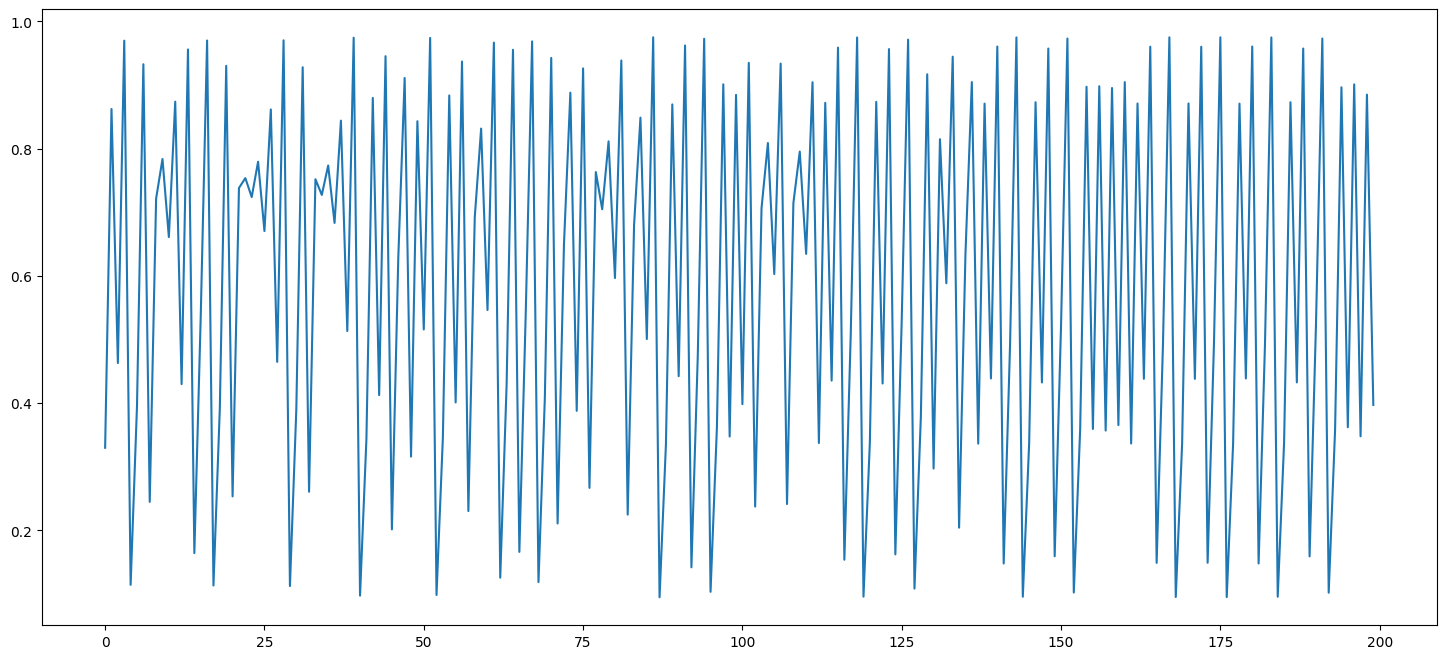

In [4]:
plt.figure(figsize=(18, 8))
plt.plot(values[0:200])
plt.show()

Let's reshape this signal into a **2-D** matrix:

In [5]:
# Create surface from array

surface = np.reshape(values, (100, 100))

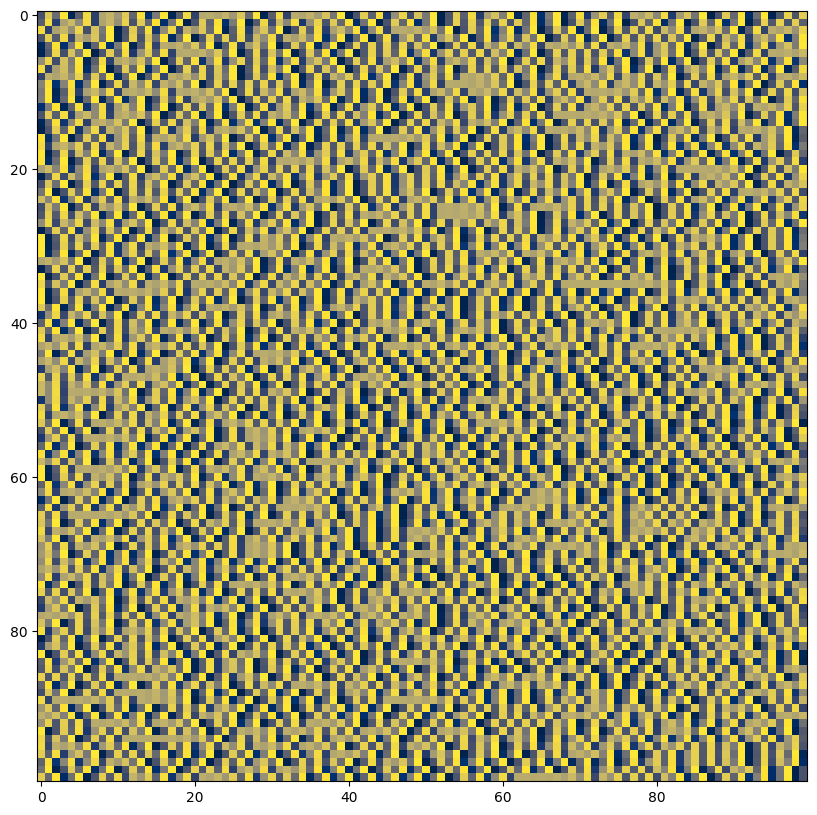

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(surface, cmap='cividis')
plt.show()

The spatial correlation of this structure is very weak. We can change it with a simple blur filter. Its size will be our **range** parameter!

In [7]:
# Slightly blur image with simple mean filter

mean_filter = np.ones(shape=(7, 7))

surf_blurred = convolve2d(surface, mean_filter, boundary='wrap')

And here we are! We have our artificial surface for testing purposes!

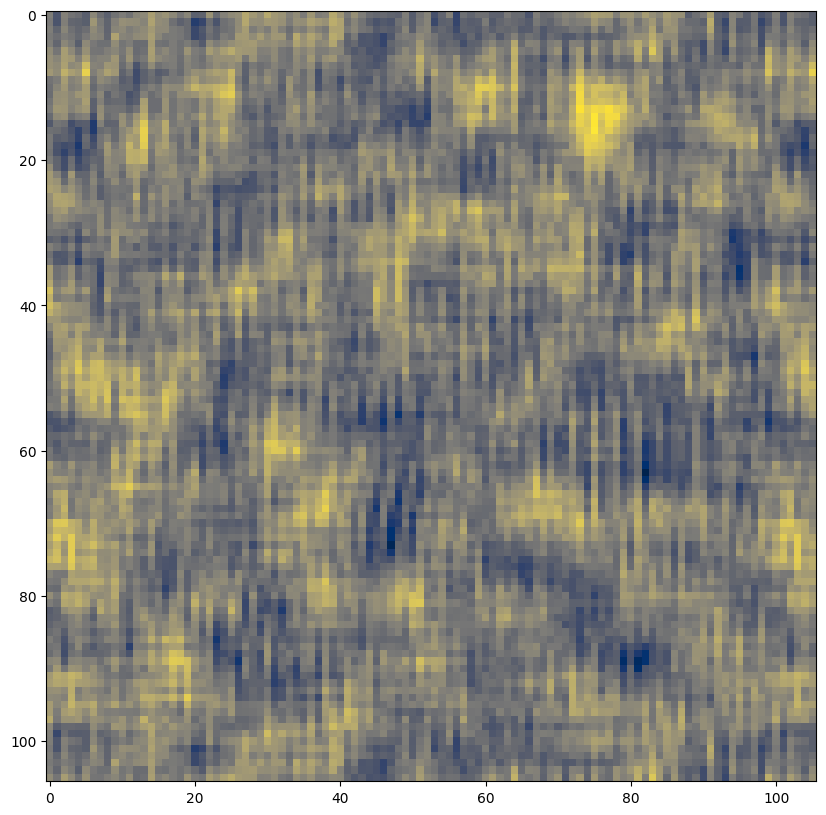

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(surf_blurred, cmap='cividis')
plt.show()

## 2) Create the experimental semivariogram

We must create the experimental variogram before we start comparing theoretical models. Our 2-D surface must be transformed into an array:

```
[[coordinate x1, coordinate y1, value1],
[coordinate x2, coordinate y2, value2],
[...],]
```

The path to transform a 2D surface into pixel coordinates has two steps. In the first step, we use `scipy` to make a sparse representation of the surface, and in the second step, we use `numpy` to transform the sparse representation into an array:

In [9]:
# Transform data into x, y, val array

In [10]:
sparse_data = coo_matrix(surf_blurred)

In [11]:
# data, col, row == value, x, y

In [12]:
xyval = np.asarray([sparse_data.col, sparse_data.row, sparse_data.data]).T

We know our data - the effective range of correlation is seven steps, and we have set the mean filter to this size. With this knowledge, we will set `step_size` into 2 units and `max_range` into 20 (way above the actual maximum range, which is 7, but we show in this way how variograms behave at a large distance).

In [13]:
# Get experimental variogram

In [14]:
experimental = build_experimental_variogram(xyval, 2, 20)

In [15]:
semivars = experimental.experimental_semivariance_array.copy()

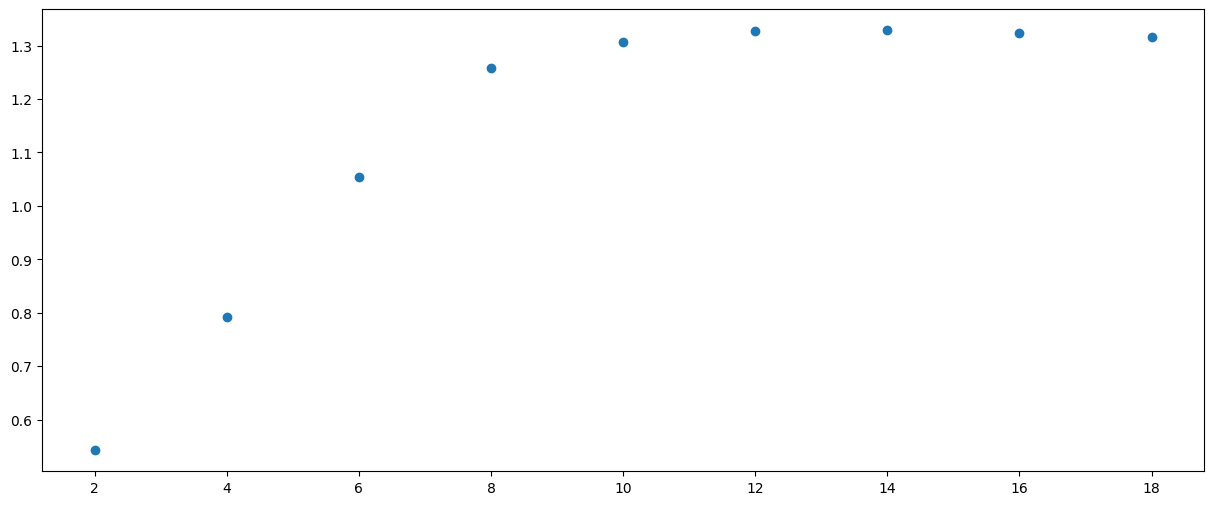

In [16]:
plt.figure(figsize=(15, 6))
plt.scatter(semivars[:, 0], semivars[:, 1])
plt.show()

We’ve read the plot and decided to set:

- **nugget** to `0`,
- **sill** to `1.3`,
- **range** to `7`,
- **lags** to list of distances from 2 to 18.

We can create the theoretical variogram from scratch without calling the `build_theoretical_variogram()` function or the `TheoreticalVariogram` class. Those three parameters and the lags are all that we need for modeling.

In [17]:
# Set nugget, sill and range

In [18]:
_nugget = 0
_sill = 1.3
_range = 7
_lags = semivars[:, 0].copy()

## 3) Set all variogram models

Variogram models are imported as external functions and are not part of any object. We can use this fact, import all models, and calculate their outputs. We will calculate and show seven different theoretical models compared to the experimental variogram.

Models to calculate:

- circular,
- cubic,
- exponential,
- gaussian,
- linear,
- power,
- spherical.

In [19]:
# Crete different models: circular, cubic, exponential, gaussian, linear, power, spherical

In [20]:
circular = circular_model(lags=_lags,
                          nugget=_nugget,
                          sill=_sill,
                          rang=_range)

cubic = cubic_model(lags=_lags,
                    nugget=_nugget,
                    sill=_sill,
                    rang=_range)

exponential = exponential_model(lags=_lags,
                                nugget=_nugget,
                                sill=_sill,
                                rang=_range)

gaussian = gaussian_model(lags=_lags,
                          nugget=_nugget,
                          sill=_sill,
                          rang=_range)

linear = linear_model(lags=_lags,
                      nugget=_nugget,
                      sill=_sill,
                      rang=_range)

power = power_model(lags=_lags,
                    nugget=_nugget,
                    sill=_sill,
                    rang=_range)

spherical = spherical_model(lags=_lags,
                            nugget=_nugget,
                            sill=_sill,
                            rang=_range)

With all models calculated, let's take a look at their output. Before we jump into the last step, which model works optimally with the experimental variogram? (It is a tricky question!)

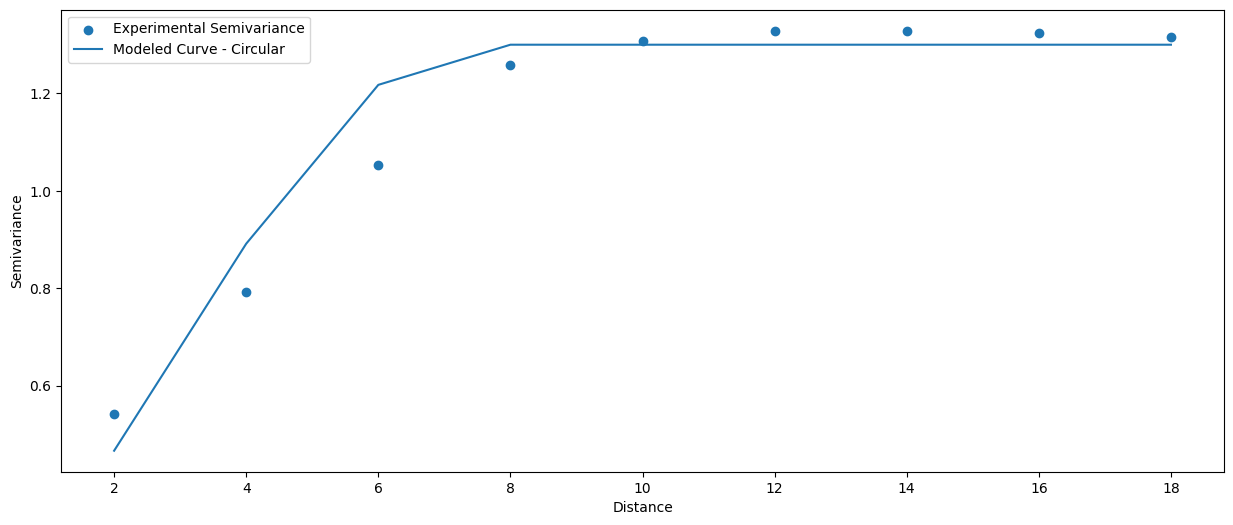

In [21]:
# Plot circular

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, circular)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Circular'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

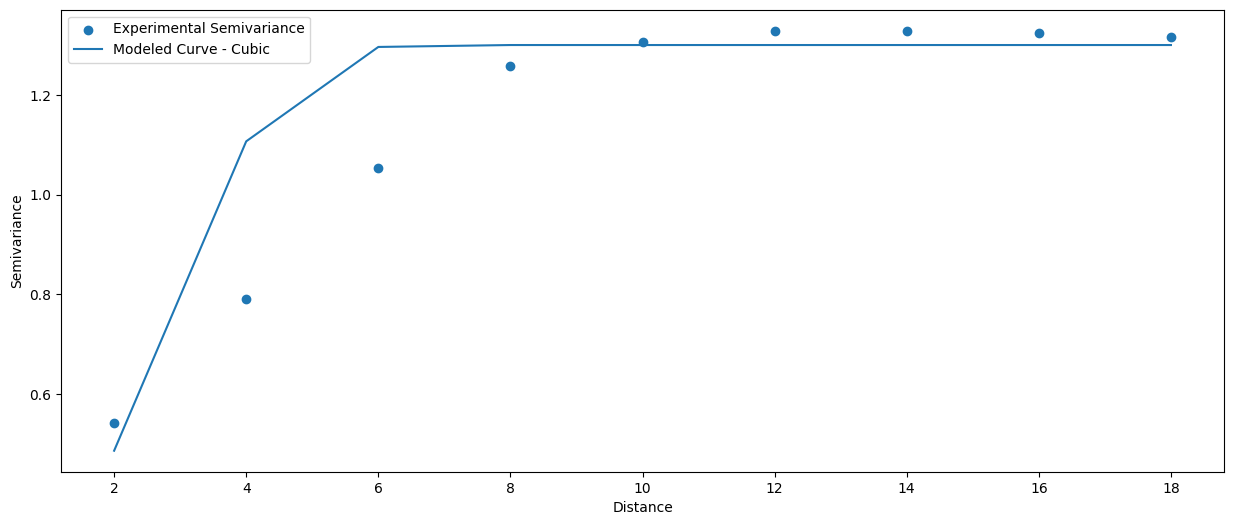

In [22]:
# Plot cubic

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, cubic)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Cubic'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

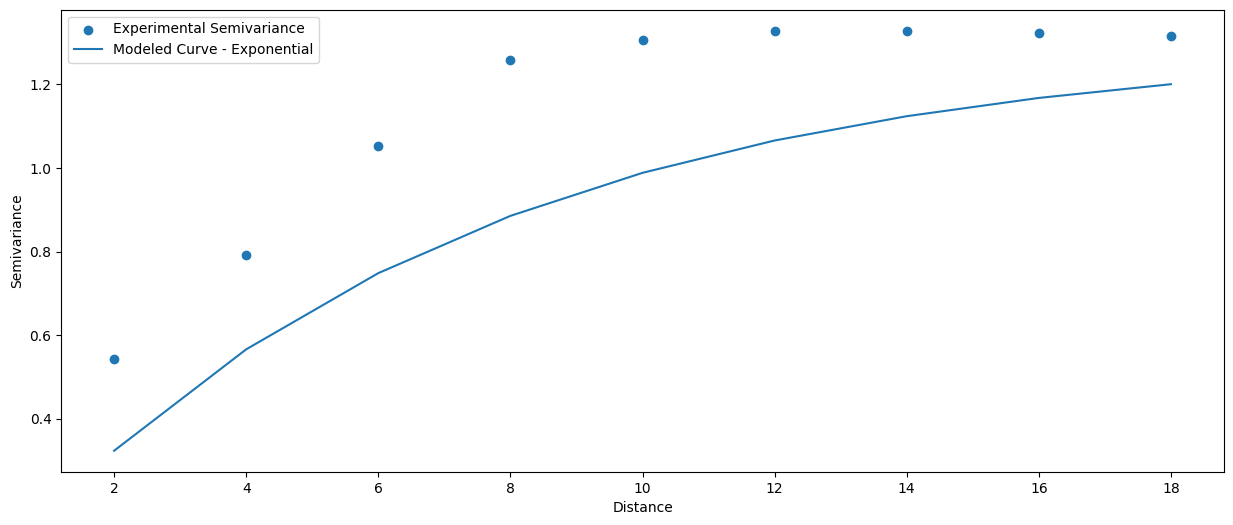

In [23]:
# Plot exponential

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, exponential)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Exponential'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

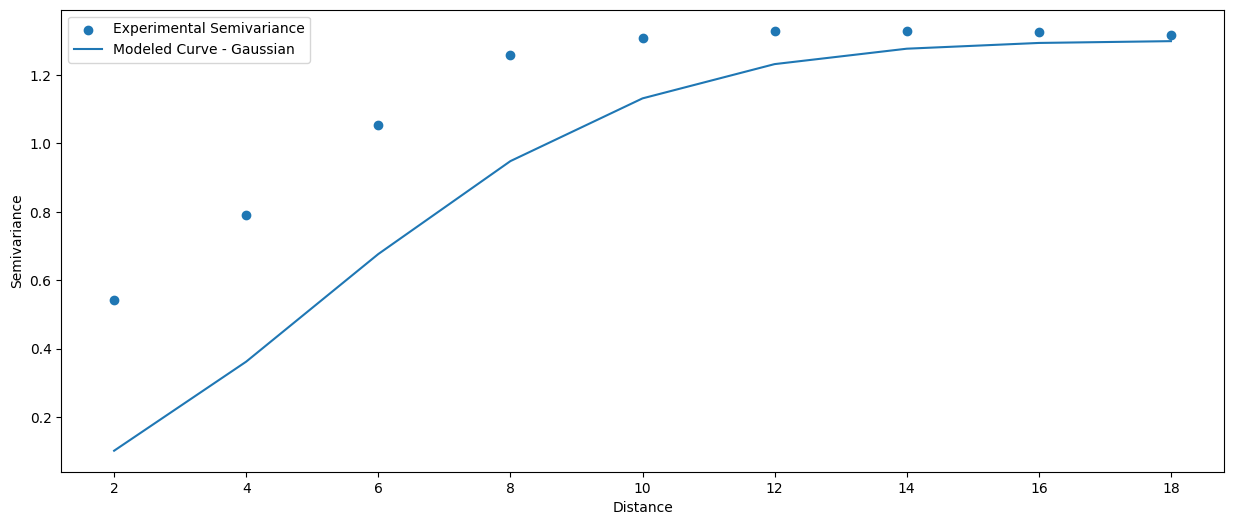

In [24]:
# Plot gaussian

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, gaussian)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Gaussian'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

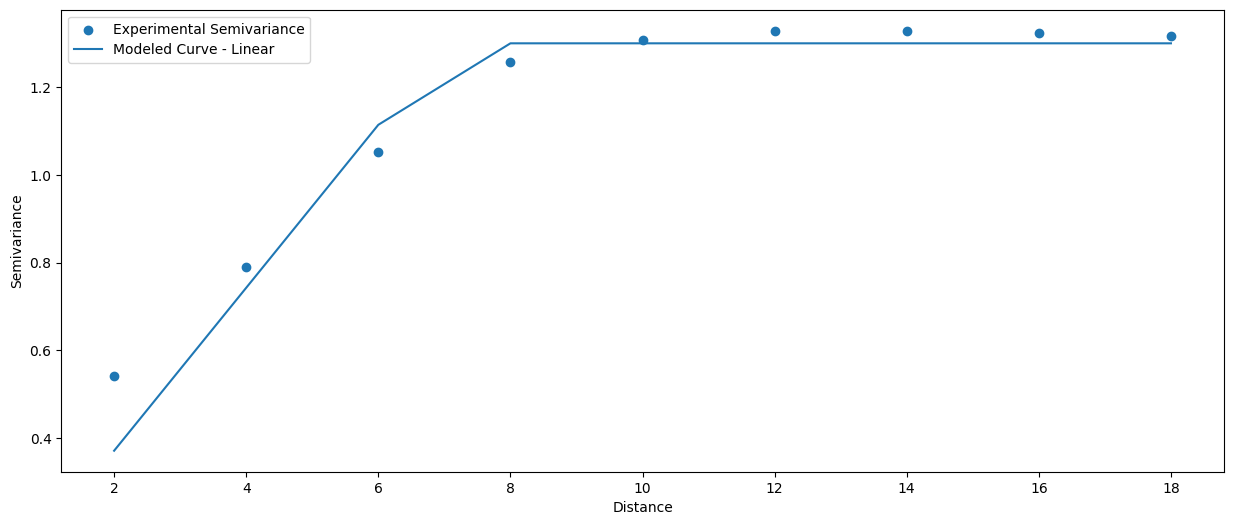

In [25]:
# Plot linear

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, linear)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Linear'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

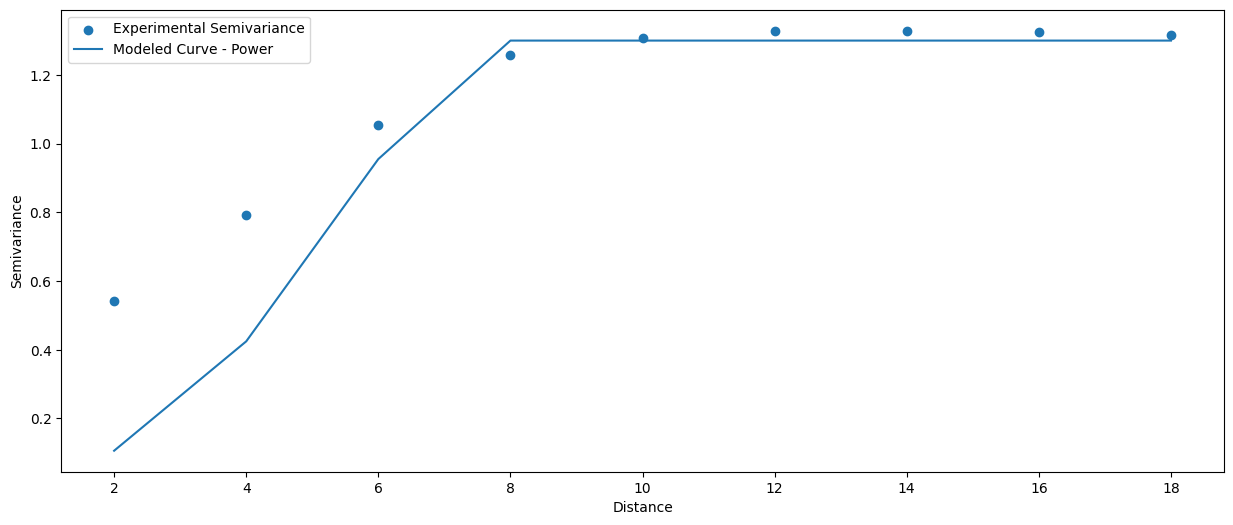

In [26]:
# Plot power

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, power)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Power'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

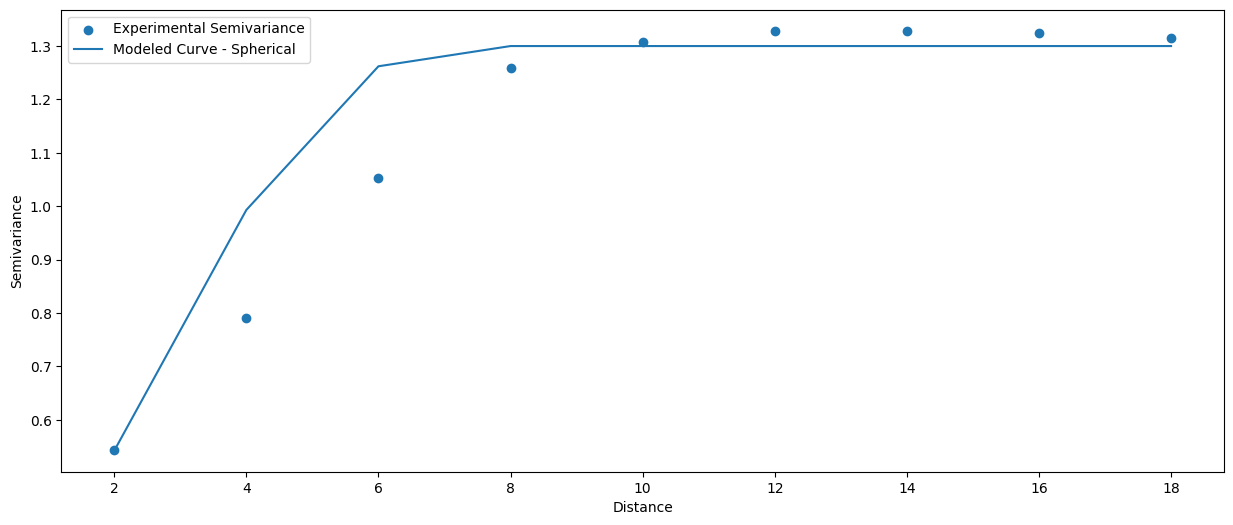

In [27]:
# Plot spherical

plt.figure(figsize=(15, 6))
plt.scatter(_lags, semivars[:, 1])
plt.plot(_lags, spherical)
plt.legend(['Experimental Semivariance', 'Modeled Curve - Spherical'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

What was your guess?

.
.
.

I hope we have chosen `circular` or `linear` models! But we should be careful with the final opinion and even more careful if we let the algorithm decide which model is the best based on the **root mean squared error metric** (RMSE). For us, the best model is always the model that has the best fit for the closest distances. A model with low RMSE may be "great" with distances from 10 to 18... which oscillate around the sill of our data and are useless for weighting (weight is constant from some distance).

## 4) Compare semivariogram models

The last part is a comparison of variogram models. We will still use our "own eyes" to decide which model is the best, but this time we will plot all of them in a single plot.

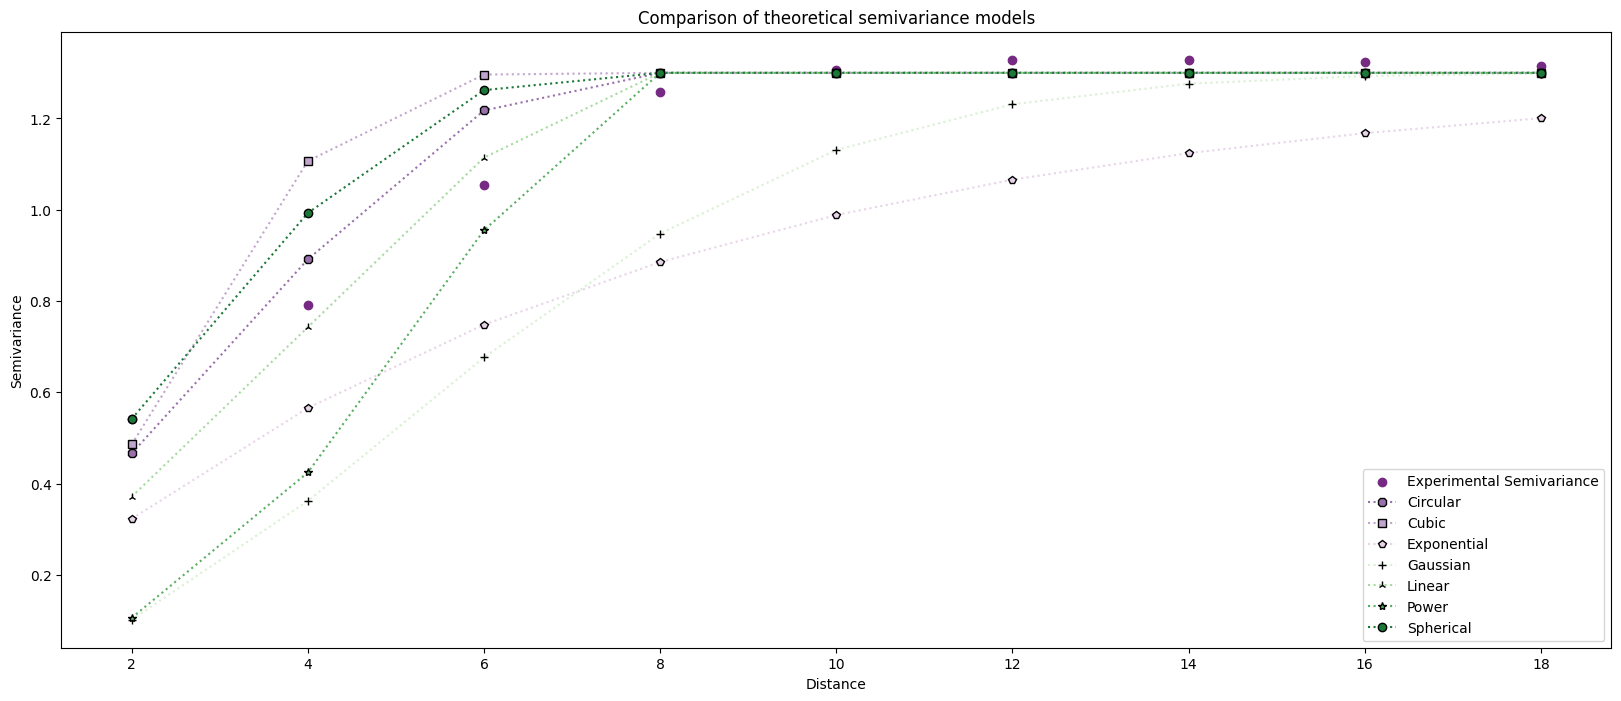

In [28]:
# Plot ALL models

plt.figure(figsize=(20, 8))
plt.scatter(_lags, semivars[:, 1], color='#762a83')
plt.plot(_lags, circular, ':8', color='#9970ab', mec='black')
plt.plot(_lags, cubic, ':s', color='#c2a5cf', mec='black')
plt.plot(_lags, exponential, ':p', color='#e7d4e8', mec='black')
plt.plot(_lags, gaussian, ':+', color='#d9f0d3', mec='black')
plt.plot(_lags, linear, ':2', color='#a6dba0', mec='black')
plt.plot(_lags, power, ':*', color='#5aae61', mec='black')
plt.plot(_lags, spherical, ':o', color='#1b7837', mec='black')
plt.title('Comparison of theoretical semivariance models')
plt.legend(['Experimental Semivariance',
            'Circular',
            'Cubic',
            'Exponential',
            'Gaussian',
            'Linear',
            'Power',
            'Spherical'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

We observe that the lowest distance from a modeled value to the experimental curve at a small distance has...

---

Where to go from here?

* A.1.3 Spatial Dependence Index
* A.2.1 Directional Semivariogram
* A.2.2 Variogram Point Cloud
* A.2.3 Experimental Variogram and Variogram Point Cloud Classes
* B.1.1 Ordinary and Simple Kriging

## Changelog

| Date | Change description                                                              | Author |
|------|---------------------------------------------------------------------------------|--------|
| 2023-08-18 | The tutorial was refreshed and set along with the 0.5.0 version of the package  | @SimonMolinsky |
| 2022-11-05 | The tutorial updated for the 0.3.5 version of the package                       | @SimonMolinsky |
| 2022-08-16 | The first release of tutorial                                                   | @SimonMolinsky |